# Imports & Carga de Datos

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
#from google.colab import drive, files


In [2]:
#drive.mount('/content/drive', force_remount=True)
#df=pd.read_csv("/content/drive/My Drive/data/data.csv", sep = ",")

df=pd.read_csv("data.csv", sep = ";")
df

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


# División del dataset: DEV y TEST

Primero separamos el dataset completo en dos subconjuntos:
- **DEV (2/3 del total)**: lo usaremos para entrenar y validar modelos.
- **TEST (1/3 del total)**: se usará **solo al final** para evaluar el mejor modelo seleccionado.


In [3]:
# División inicial: DEV y TEST
X_dev, X_test, Y_dev, Y_test = train_test_split(
    df.drop('Target', axis=1),
    df['Target'],
    test_size=(1/3),  # 33% para test
    random_state=42
)

# División del set DEV en TRAIN y VALIDATION

El set de desarrollo (DEV) se divide a su vez en:
- **TRAIN (2/3 del DEV)**: para entrenar los modelos.
- **VALIDATION (1/3 del DEV)**: para evaluar diferentes hiperparámetros y seleccionar el mejor modelo.


### Hacer una nueva division del dataset Dev en train+val

In [4]:
# División del DEV en TRAIN y VAL
X_train, X_val, Y_train, Y_val = train_test_split(
    X_dev,
    Y_dev,
    test_size=(1/3),  # 33% del DEV → 22% del total
    random_state=42
)


In [5]:
print("Tamaños de los subconjuntos:")
print(f"Train:      {X_train.shape[0]} muestras")
print(f"Validation: {X_val.shape[0]} muestras")
print(f"Test:       {X_test.shape[0]} muestras")

# Porcentajes sobre el total
total = df.shape[0]
train_pct = (X_train.shape[0] / total) * 100
val_pct   = (X_val.shape[0] / total) * 100
test_pct  = (X_test.shape[0] / total) * 100

print("\nPorcentajes respecto al total:")
print(f"Train:      {train_pct:.2f}%")
print(f"Validation: {val_pct:.2f}%")
print(f"Test:       {test_pct:.2f}%")


Tamaños de los subconjuntos:
Train:      1966 muestras
Validation: 983 muestras
Test:       1475 muestras

Porcentajes respecto al total:
Train:      44.44%
Validation: 22.22%
Test:       33.34%


# Hold-Out

En este método, entrenamos el modelo en el conjunto de **train** y lo evaluamos en el conjunto de **validación**.

El objetivo es comparar distintos valores del hiperparámetro `max_depth` y elegir el que da mejor rendimiento en validación.

Luego, reentrenamos el modelo completo con `train + validation` y lo evaluamos **una única vez** en el conjunto de **test**.


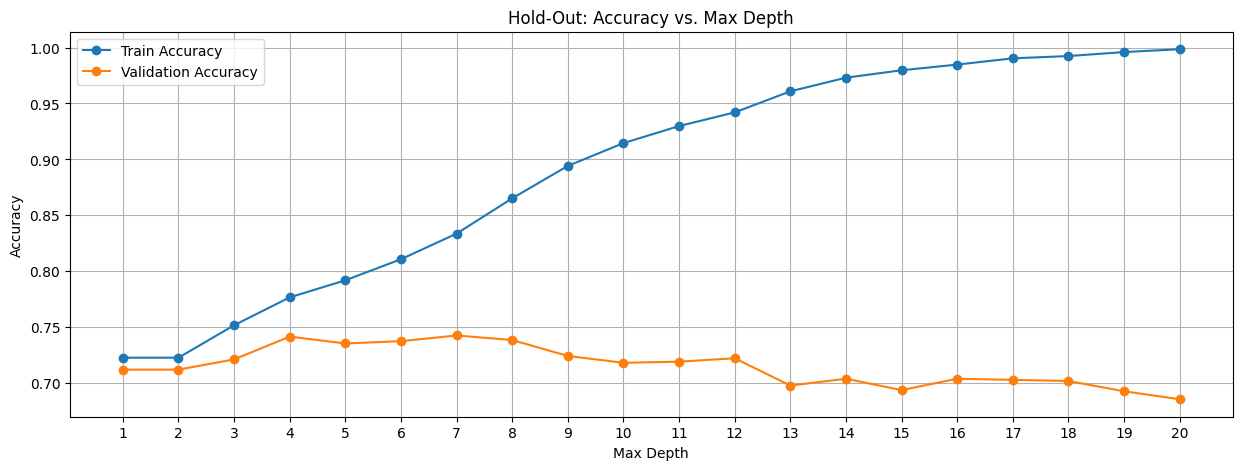

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

depths = range(1, 21) 
train_scores = []
val_scores = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(X_train, Y_train)

    train_acc = accuracy_score(Y_train, clf.predict(X_train))
    val_acc = accuracy_score(Y_val, clf.predict(X_val))

    train_scores.append(train_acc)
    val_scores.append(val_acc)

# Graficar resultados
plt.figure(figsize=(15, 5))
plt.plot(depths, train_scores, label="Train Accuracy", marker='o')
plt.plot(depths, val_scores, label="Validation Accuracy", marker='o')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Hold-Out: Accuracy vs. Max Depth")
plt.legend()
plt.grid(True)
plt.xticks(depths)
plt.show()


In [9]:
best_depth = depths[val_scores.index(max(val_scores))]
print(f"Mejor profundidad (según validación): {best_depth}")

X_dev_full = pd.concat([X_train, X_val])
y_dev_full = pd.concat([Y_train, Y_val])


final_clf = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
final_clf.fit(X_dev_full, y_dev_full)

# Evaluamos en test
test_acc = accuracy_score(Y_test, final_clf.predict(X_test))
print(f"Accuracy final en TEST: {test_acc:.3f}")

acc_holdout = test_acc
depth_holdout = best_depth



Mejor profundidad (según validación): 7
Accuracy final en TEST: 0.728


# Repeated Hold-Out

Una sola partición puede ser poco representativa, por eso repetimos el proceso de Hold-Out varias veces con distintas semillas.

Para cada repetición, volvemos a dividir el conjunto de desarrollo (DEV) en `train` y `val`, entrenamos el modelo para varias profundidades, y almacenamos los resultados.

Finalmente, promediamos los valores de validación para cada profundidad, lo que nos da una visión más robusta y menos dependiente del azar.


In [10]:
n_repeats = 10
depths = range(1, 21)

train_scores_per_depth = []
val_scores_per_depth = []

for i in range(n_repeats):
    # Nueva división train/val sobre el DEV
    X_train_i, X_val_i, Y_train_i, Y_val_i = train_test_split(
        X_dev, Y_dev, test_size=(1/3), random_state=42 + i
    )

    train_scores = []
    val_scores = []

    for d in depths:
        clf = DecisionTreeClassifier(max_depth=d, random_state=42)
        clf.fit(X_train_i, Y_train_i)

        train_acc = accuracy_score(Y_train_i, clf.predict(X_train_i))
        val_acc = accuracy_score(Y_val_i, clf.predict(X_val_i))

        train_scores.append(train_acc)
        val_scores.append(val_acc)

    train_scores_per_depth.append(train_scores)
    val_scores_per_depth.append(val_scores)


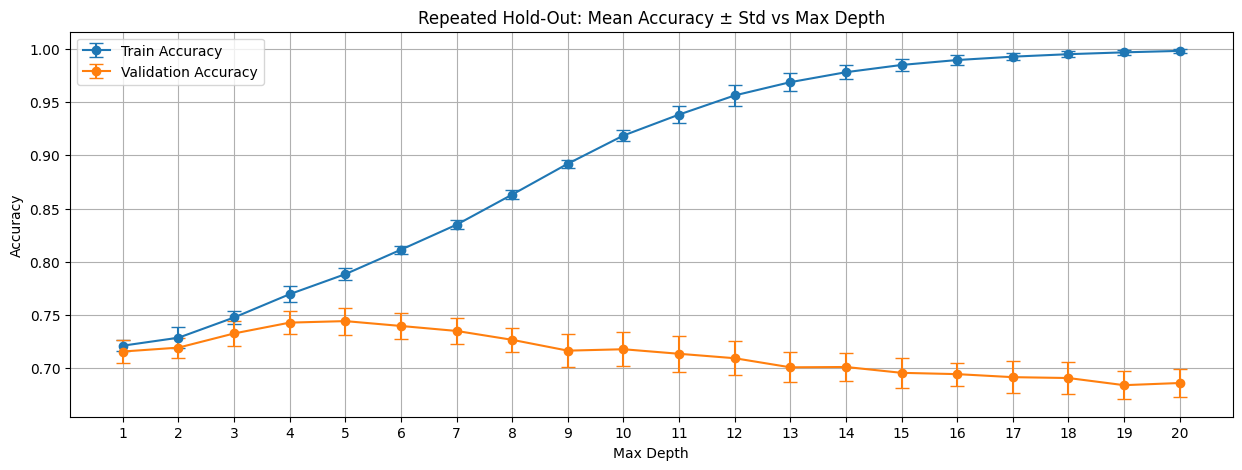

In [11]:
val_scores_per_depth = np.array(val_scores_per_depth)
train_scores_per_depth = np.array(train_scores_per_depth)

val_mean_scores = val_scores_per_depth.mean(axis=0)
val_std_scores = val_scores_per_depth.std(axis=0)

train_mean_scores = train_scores_per_depth.mean(axis=0)
train_std_scores = train_scores_per_depth.std(axis=0)


# Graficar resultados
plt.figure(figsize=(15, 5))
plt.errorbar(depths, train_mean_scores, yerr=train_std_scores, label="Train Accuracy", marker='o', capsize=5)
plt.errorbar(depths, val_mean_scores, yerr=val_std_scores, label="Validation Accuracy", marker='o', capsize=5)
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Repeated Hold-Out: Mean Accuracy ± Std vs Max Depth")
plt.legend()
plt.grid(True)
plt.xticks(depths)
plt.show()


In [12]:
# Elegimos la mejor profundidad según el promedio de validación
best_depth = depths[np.argmax(val_mean_scores)]
print(f"Mejor profundidad (según validación promedio): {best_depth}")

# Entrenamos el modelo final con todo el set de desarrollo
final_clf = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
final_clf.fit(X_dev, Y_dev)

# Evaluamos en el set de test
test_acc = accuracy_score(Y_test, final_clf.predict(X_test))
print(f"Accuracy final en TEST: {test_acc:.3f}")
acc_repeated = test_acc
depth_repeated = best_depth



Mejor profundidad (según validación promedio): 5
Accuracy final en TEST: 0.732


# Cross-Validation (K-Fold)

Otra forma común de seleccionar hiperparámetros es mediante validación cruzada (Cross-Validation).

Dividimos el set de desarrollo (`DEV`) en **K bloques (folds)**. Entrenamos el modelo K veces, cada vez usando uno de los bloques como validación y los otros K-1 como entrenamiento.

Calculamos el promedio y la desviación estándar del rendimiento. Esto reduce la varianza del estimador y permite aprovechar mejor los datos de entrenamiento.


In [13]:
from sklearn.model_selection import cross_validate

depths = range(1, 21)
cv = 5  # número de folds

avg_train_scores = []
avg_val_scores = []
train_stds = []
val_stds = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    
    scores = cross_validate(
        clf,
        X_train,
        Y_train,
        cv=cv,
        scoring='accuracy',
        return_train_score=True
    )
    
    avg_train_scores.append(np.mean(scores['train_score']))
    train_stds.append(np.std(scores['train_score']))
    
    avg_val_scores.append(np.mean(scores['test_score']))
    val_stds.append(np.std(scores['test_score']))


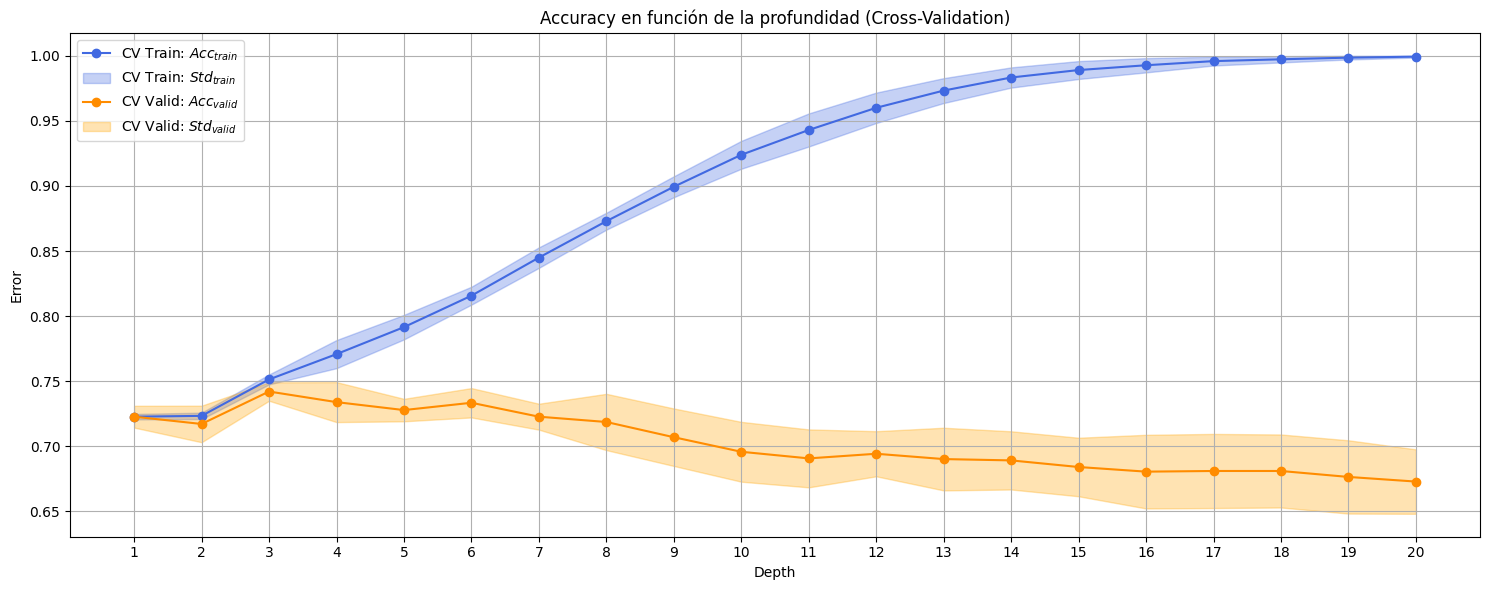

In [14]:
avg_train_scores = np.array(avg_train_scores)
avg_val_scores = np.array(avg_val_scores)
train_stds = np.array(train_stds)
val_stds = np.array(val_stds)

# Graficamos con sombreado
plt.figure(figsize=(15, 6))

# Train
plt.plot(depths, avg_train_scores, color='royalblue', marker='o', label=r"CV Train: $Acc_{train}$")
plt.fill_between(
    depths,
    avg_train_scores - train_stds,
    avg_train_scores + train_stds,
    alpha=0.3,
    color='royalblue',
    label=r"CV Train: $Std_{train}$"
)

# Validation
plt.plot(depths, avg_val_scores, color='darkorange', marker='o', label=r"CV Valid: $Acc_{valid}$")
plt.fill_between(
    depths,
    avg_val_scores - val_stds,
    avg_val_scores + val_stds,
    alpha=0.3,
    color='orange',
    label=r"CV Valid: $Std_{valid}$"
)

plt.xlabel("Depth")
plt.ylabel("Error")
plt.title("Accuracy en función de la profundidad (Cross-Validation)")
plt.grid(True)
plt.legend()
plt.xticks(depths)
plt.tight_layout()
plt.show()

In [16]:
best_depth_cv = depths[np.argmax(avg_val_scores)]
print(f"Mejor profundidad (según CV): {best_depth_cv}")

# Reentrenamos con todo X_train (DEV completo)
final_clf_cv = DecisionTreeClassifier(max_depth=best_depth_cv, random_state=42)
final_clf_cv.fit(X_train, Y_train)

# Evaluamos en TEST
test_acc_cv = accuracy_score(Y_test, final_clf_cv.predict(X_test))
print(f"Accuracy final en TEST (modelo elegido por CV): {test_acc_cv:.3f}")
acc_cv_full = test_acc
depth_cv_full = best_depth



Mejor profundidad (según CV): 3
Accuracy final en TEST (modelo elegido por CV): 0.721


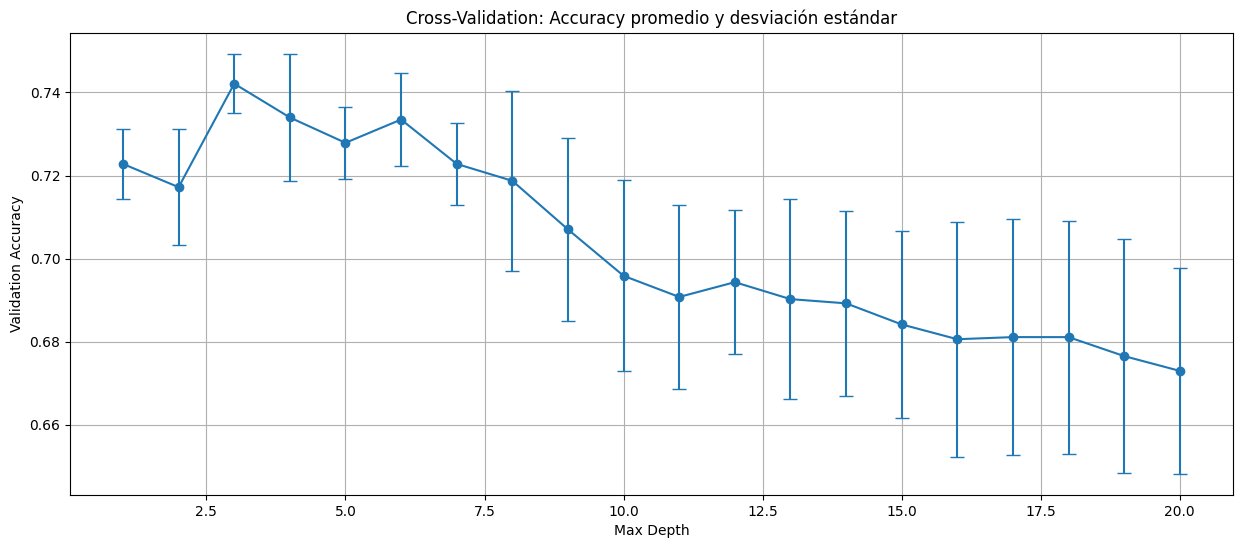

In [17]:
plt.figure(figsize=(15, 6))
plt.errorbar(depths, avg_val_scores, yerr=val_stds, fmt='-o', capsize=5)
plt.xlabel("Max Depth")
plt.ylabel("Validation Accuracy")
plt.title("Cross-Validation: Accuracy promedio y desviación estándar")
plt.grid(True)
plt.show()


### Alternativa con `cross_val_score`

Usamos `cross_val_score` para obtener únicamente los valores de validación cruzada (sin incluir los de entrenamiento).  
Es útil cuando solo nos interesa evaluar el rendimiento general del modelo con distintas profundidades.


In [18]:
from sklearn.model_selection import cross_val_score

depths = range(1, 21)
cv_scores_mean = []
cv_scores_std = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    scores = cross_val_score(clf, X_train, Y_train, cv=5, scoring='accuracy')
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())


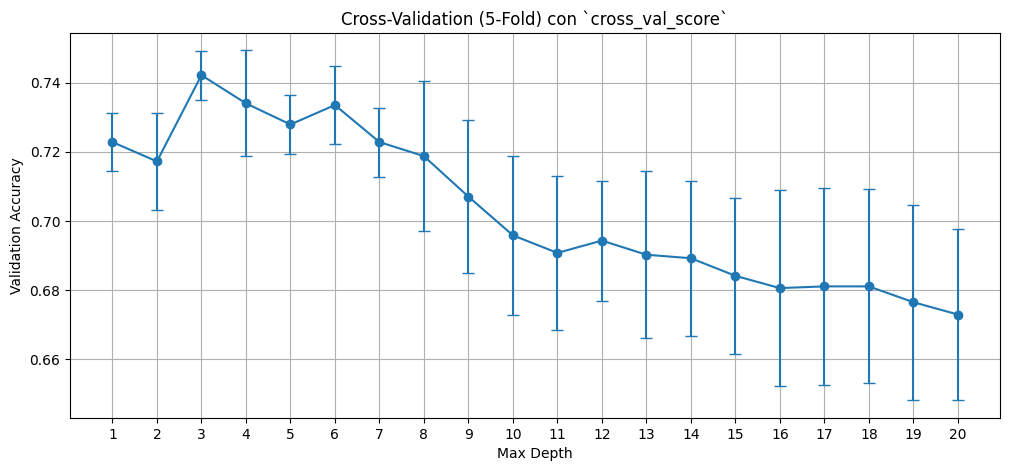

In [19]:
plt.figure(figsize=(12, 5))
plt.errorbar(depths, cv_scores_mean, yerr=cv_scores_std, fmt='-o', capsize=4)
plt.xlabel("Max Depth")
plt.ylabel("Validation Accuracy")
plt.title("Cross-Validation (5-Fold) con `cross_val_score`")
plt.grid(True)
plt.xticks(depths)
plt.show()


In [20]:
best_depth = depths[np.argmax(cv_scores_mean)]
print(f"Mejor profundidad (según cross_val_score): {best_depth}")

final_clf = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
final_clf.fit(X_dev, Y_dev)

test_acc = accuracy_score(Y_test, final_clf.predict(X_test))
print(f"Accuracy final en TEST: {test_acc:.3f}")

acc_cv_simple = test_acc
depth_cv_simple = best_depth



Mejor profundidad (según cross_val_score): 3
Accuracy final en TEST: 0.725


# Evaluación

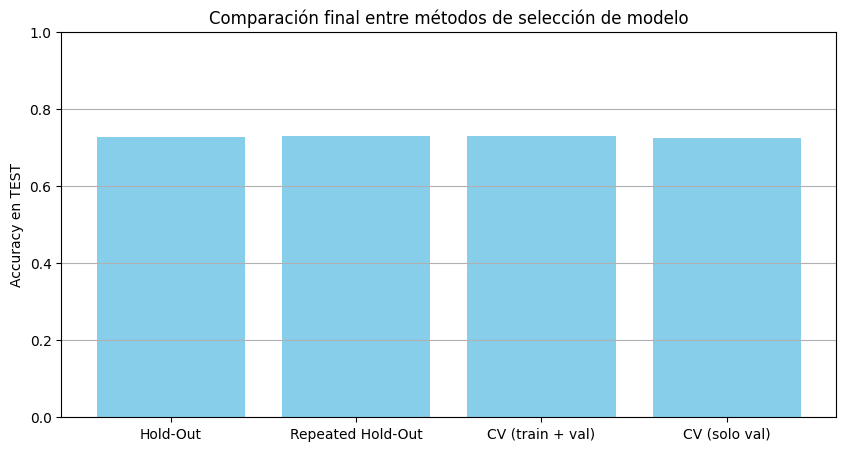

In [21]:
# Crear diccionario con los resultados
acc_dict = {
    "Hold-Out": acc_holdout,
    "Repeated Hold-Out": acc_repeated,
    "CV (train + val)": acc_cv_full,
    "CV (solo val)": acc_cv_simple,
}

# Si usaste también cross_val_score, descomentá la siguiente línea:
acc_dict["CV (solo val)"] = acc_cv_simple

# Graficar
plt.figure(figsize=(10, 5))
plt.bar(acc_dict.keys(), acc_dict.values(), color='skyblue')
plt.ylabel("Accuracy en TEST")
plt.title("Comparación final entre métodos de selección de modelo")
plt.ylim(0, 1.0)
plt.grid(axis='y')
plt.show()


In [22]:
import pandas as pd

# Crear DataFrame con resultados
results_df = pd.DataFrame({
    "Método": ["Hold-Out", "Repeated Hold-Out", "CV (train + val)"],
    "Profundidad seleccionada": [depth_holdout, depth_repeated, depth_cv_full],
    "Accuracy en TEST": [acc_holdout, acc_repeated, acc_cv_full]
})

results_df.loc[len(results_df.index)] = ["CV (solo val)", depth_cv_simple, acc_cv_simple]

# Mostrar la tabla
results_df


,Método,Profundidad seleccionada,Accuracy en TEST
0,Hold-Out,7,0.728136
1,Repeated Hold-Out,5,0.731525
2,CV (train + val),5,0.731525
3,CV (solo val),3,0.725424


## Reflexión final: comparación entre métodos

Los diferentes métodos de selección de modelos nos llevaron a elegir distintas profundidades óptimas para el árbol de decisión:

- **Hold-Out** eligió una profundidad de **7**, pero al basarse en una única partición, su estimación puede estar más expuesta al azar.
- **Repeated Hold-Out** y **Cross-Validation (train + val)** coincidieron en seleccionar una profundidad de **5**, lo que sugiere una mayor estabilidad en su estimación.
- **Cross-Validation (solo val)** eligió una profundidad menor (**3**), posiblemente por ser más conservador al no tener en cuenta el rendimiento sobre el set de entrenamiento.

La **accuracy final en el conjunto de test** fue similar en todos los casos, pero las pequeñas diferencias muestran cómo la elección del método de validación puede influir en la selección del modelo final.


# Práctico: Selección de modelos con árboles de decisión

En este práctico vas a aplicar todo lo aprendido sobre selección de modelos utilizando árboles de decisión.

Trabajaremos con el dataset **Heart Disease (Statlog)** y tendrás que:
- Cargar y preparar los datos
- Separar en conjuntos de entrenamiento, validación y test
- Explorar distintos valores de `max_depth`
- Utilizar `GridSearchCV` para automatizar la búsqueda
- Evaluar el mejor modelo en el set de test


## Ejercicio 1: Carga de datos

1. Separá los datos en `X` (features) e `y` (target)
2. Mostrá las primeras filas y los tipos de datos


In [ ]:
from sklearn.datasets import fetch_openml
heart = fetch_openml("heart-statlog", as_frame=True)
heart_df = heart.frame 
heart_df.head()

,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,class
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,present
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,absent
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,present
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,absent
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,absent


## Ejercicio 2: División de datos

1. Dividí el dataset en:
   - **DEV** (2/3 del total)
   - **TEST** (1/3 del total)

2. Luego dividí el set **DEV** en:
   - **TRAIN** (2/3 del DEV)
   - **VALIDATION** (1/3 del DEV)

3. Mostrá cuántas muestras hay en cada conjunto y sus porcentajes.


In [33]:
X_dev_heart, X_test_heart, Y_dev_heart, Y_test_heart = train_test_split(
  heart_df.drop('class', axis = 1),
  heart_df['class'],
  test_size=(1/3),
  random_state=42
)

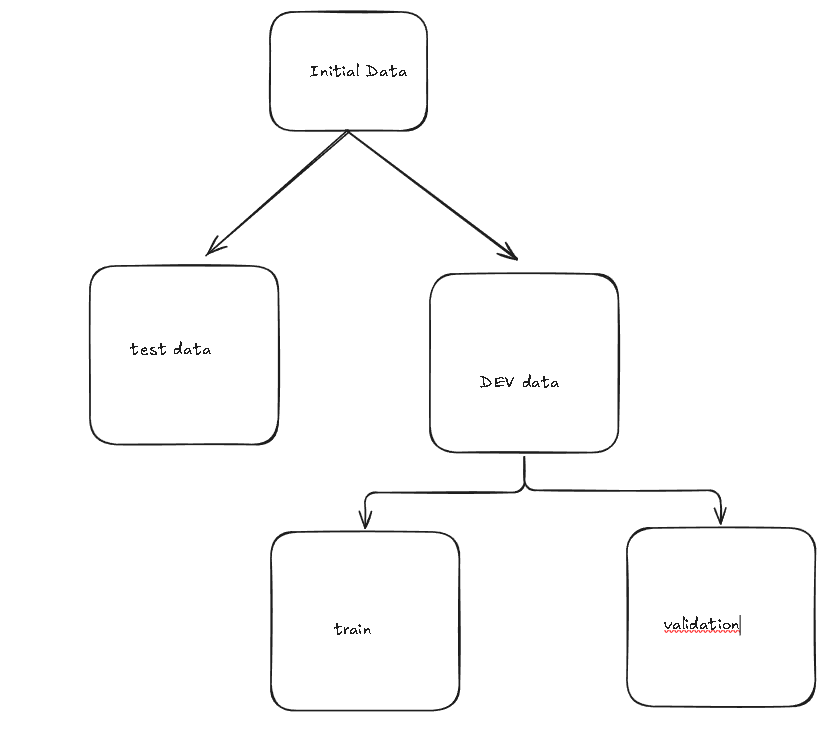

In [36]:
# División del DEV en TRAIN y VAL
X_train_heart, X_val_heart, Y_train_heart, Y_val_heart = train_test_split(
    X_dev_heart,
    Y_dev_heart,
    test_size=(1/3),  
    random_state=42
)
print("Tamaños de los subconjuntos:")
print(f"Train:      {X_train_heart.shape[0]} muestras")
print(f"Validation: {X_val_heart.shape[0]} muestras")
print(f"Test:       {X_test_heart.shape[0]} muestras")

# Porcentajes sobre el total
total = heart_df.shape[0]
train_pct = (X_train_heart.shape[0] / total) * 100
val_pct   = (X_val_heart.shape[0] / total) * 100
test_pct  = (X_test_heart.shape[0] / total) * 100

print("\nPorcentajes respecto al total:")
print(f"Train:      {train_pct:.2f}%")
print(f"Validation: {val_pct:.2f}%")
print(f"Test:       {test_pct:.2f}%")

Tamaños de los subconjuntos:
Train:      120 muestras
Validation: 60 muestras
Test:       90 muestras

Porcentajes respecto al total:
Train:      44.44%
Validation: 22.22%
Test:       33.33%


## Ejercicio 3: Árboles con distintas profundidades

Entrená un árbol de decisión para distintos valores de `max_depth` (de 1 a 20).

1. Evaluá el accuracy en `train` y `val` usando hold-out, repeated hold-out y cross-validation.
2. Graficá las curvas de rendimiento
3. Elegí la mejor profundidad según validación


In [37]:
depths = range(1, 21) 
train_scores = []
val_scores = []

for d in depths:
  tree = DecisionTreeClassifier(max_depth=d, random_state=42)
  tree.fit(X_train_heart,Y_train_heart)
  
  train_acc_tree = accuracy_score(Y_train_heart, tree.predict(X_train_heart))
  value_accuracy = accuracy_score(Y_val_heart, tree.predict(X_val_heart))

  train_scores.append(train_acc_tree)
  val_scores.append(value_accuracy)


## Ejercicio 4: Selección automática con GridSearchCV

Usá `GridSearchCV` con validación cruzada (`cv=5`) para buscar los mejores hiperparámetros del árbol de decisión.

1. Mostrá la mejor profundidad encontrada y el rendimiento asociado
2. Graficá `mean_test_score` vs `max_depth`
3. Compará con la elección manual anterior

Link al método: [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [ ]:
# TODO

## Ejercicio 5: Evaluación en el conjunto de TEST

1. Reentrená un modelo final con `TRAIN + VALIDATION` usando los mejores hiperparámetros encontrados en el paso anterior.
2. Evaluá el modelo en el conjunto de `TEST`
3. Reportá el accuracy final y reflexioná sobre el rendimiento obtenido


In [ ]:
# TODO